In [1]:
import numpy as np
import tensorflow as tf
from source.vq_vae import VQ_VAE
from source.vq_gan import VQ_Gan
from source.utils import WarmUp
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 256

imdir = "D:/Datasets/MGG/new_patches"


class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()

        self.flip_img = tf.keras.layers.RandomFlip(seed=seed)
        self.flip_mask = tf.keras.layers.RandomFlip(seed=seed)

        self.rnd_bright_img = tf.keras.layers.RandomBrightness(
            factor=0.2, value_range=(0, 1), seed=seed
        )
        self.rnd_bright_msk = tf.keras.layers.RandomBrightness(
            factor=0.2, value_range=(0, 1), seed=seed
        )

        self.rnd_cntr_img = tf.keras.layers.RandomContrast(factor=0.2, seed=seed)
        self.rnd_cntr_msk = tf.keras.layers.RandomContrast(factor=0.2, seed=seed)

    def call(self, inputs, labels):

        inputs = self.flip_img(inputs)
        labels = self.flip_mask(labels)

        inputs = self.rnd_bright_img(inputs)
        labels = self.rnd_bright_msk(labels)

        inputs = self.rnd_cntr_img(inputs)
        labels = self.rnd_cntr_msk(labels)

        return inputs, labels


class Augment2(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()

        self.flip_img = tf.keras.layers.RandomFlip(seed=seed)

        self.rnd_bright_img = tf.keras.layers.RandomBrightness(
            factor=0.2, value_range=(0, 255), seed=seed
        )

        self.rnd_cntr_img = tf.keras.layers.RandomContrast(factor=0.2, seed=seed)

    def call(self, inputs):

        # inputs = self.flip_img(inputs)
        # inputs = self.rnd_bright_img(inputs)
        # inputs = self.rnd_cntr_img(inputs)

        labels = inputs


        return inputs, labels

train_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir,
    labels=None,
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    seed=42,
    validation_split=0.1,
    subset="training",
)

val_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir,
    labels=None,
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    seed=42,
    validation_split=0.1,
    subset="validation",
)


train_imgs = train_imgs.batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_imgs = val_imgs.batch(batch_size=BATCH_SIZE, drop_remainder=True)


def rescale(img):
    rescale_img = tf.keras.layers.Rescaling(scale=1.0 / 255.0)
    img = rescale_img(img)

    return img

# train_images = train_imgs.map(Augment2())

train_imgs = train_imgs.map(rescale)
val_imgs = val_imgs.map(rescale)

# train_ds = train_ds.cache()
# val_imgs = val_imgs.cache()

train_imgs = train_imgs.prefetch(buffer_size=tf.data.AUTOTUNE)
val_imgs = val_imgs.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 48860 files belonging to 1 classes.
Using 43974 files for training.
Found 48860 files belonging to 1 classes.
Using 4886 files for validation.


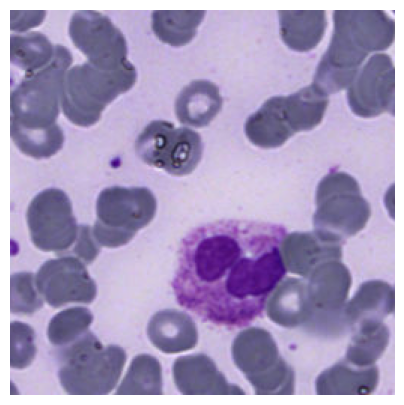

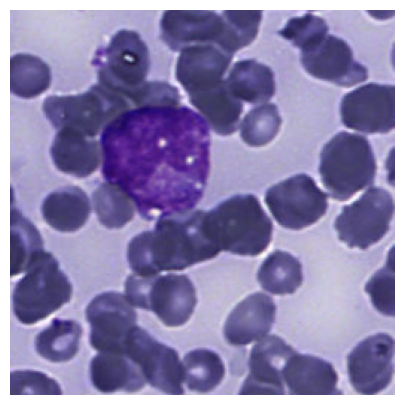

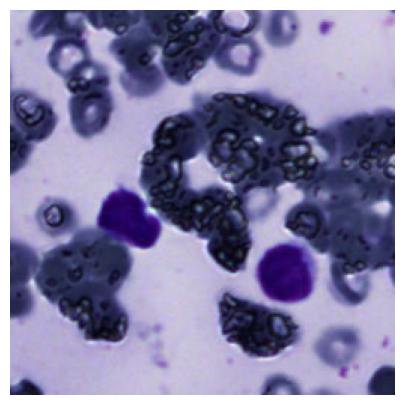

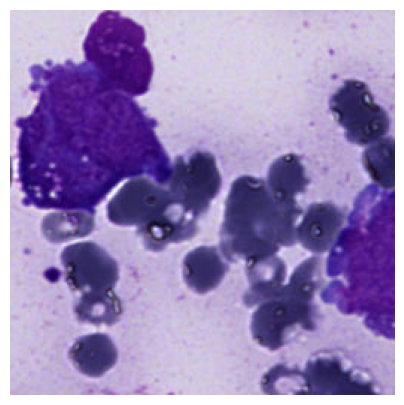

In [3]:
for img in train_imgs.take(1):

    for i in range(4):
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        ax1.imshow(img[i].numpy())
        ax1.axis('off')

In [4]:
EPOCHS = 100
WU_EPOCHS = 10

steps_per_epoch = train_imgs.cardinality().numpy()
disc_optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4, decay_steps=EPOCHS * steps_per_epoch
    )
)


wu_lr_function =  WarmUp(
    tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4, decay_steps=(EPOCHS - WU_EPOCHS) * steps_per_epoch
    ),
    start_lr=1e-5,
    target_lr=1e-4,
    warmup_steps=WU_EPOCHS * steps_per_epoch,
)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=wu_lr_function)

In [5]:
vq_gan = VQ_Gan(
    input_shape=(256, 256, 3),
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer,
    initial_dim=48,
    num_vectors=128,
)


In [6]:
vq_gan.compile()

In [ ]:
history = vq_gan.fit(train_imgs, epochs=EPOCHS, validation_data=val_imgs, 
                    callbacks=[
                                tf.keras.callbacks.ModelCheckpoint(
                                    "vqgan.h5",
                                    save_weights_only=True,
                                    save_best_only=True,
                                    monitor='val_generator_loss',
                                    mode="min",
                                ),
                                tf.keras.callbacks.EarlyStopping(
                                    monitor="val_generator_loss",
                                    min_delta=1e-4,
                                    patience=20,
                                    verbose=True,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=True,
                                ),
                            ],)

In [10]:
vq_gan.load_weights('vqgan.h5')

1/1 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


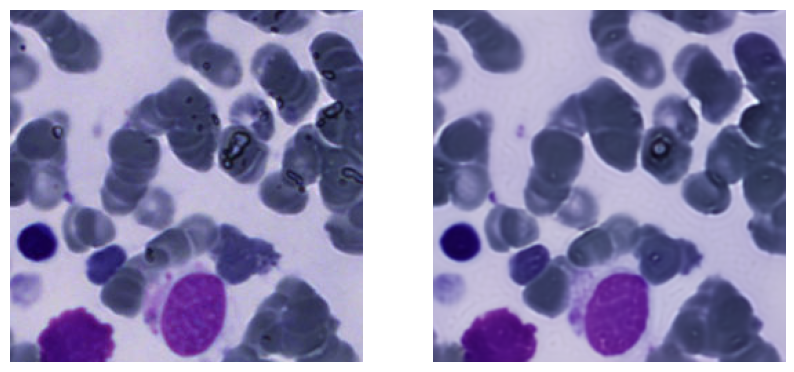

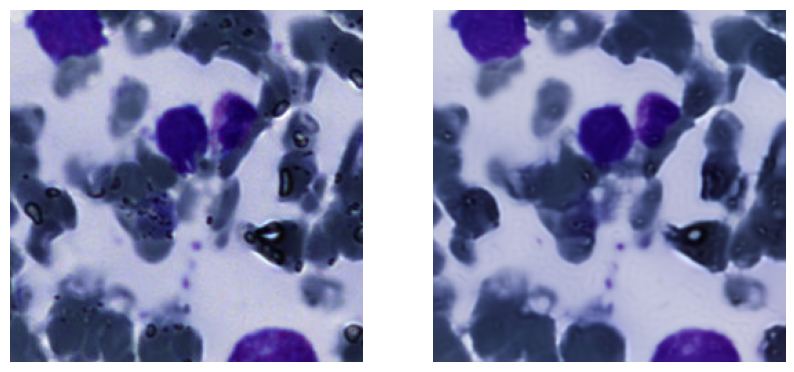

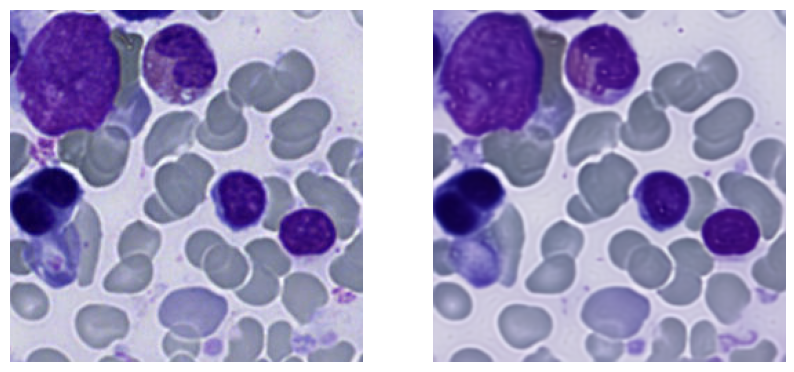

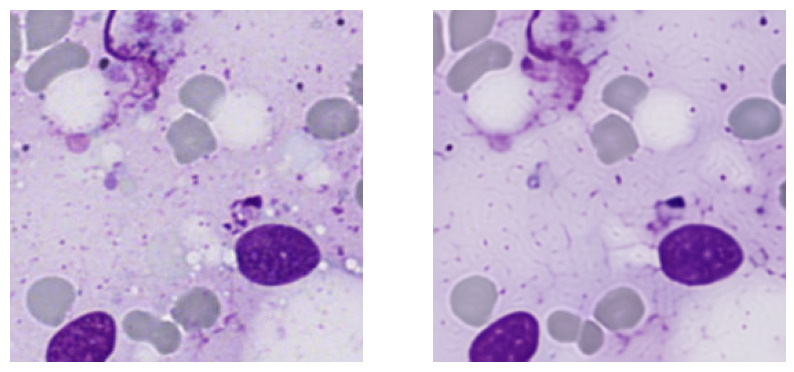

In [14]:
for img in val_imgs.take(1):

    pred = vq_gan.predict(img)

    for i in range(4):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
        ax1.imshow(img[i].numpy())
        ax2.imshow(pred[i])
        ax1.axis('off') ; ax2.axis('off')